# Homework Assignment 3 "Recommender System" take 04

## Setup

In [1]:
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error


## Load Data

In [2]:
file_path = "../../data/assignment_03/"

baskets_pq = "baskets.parquet"
coupons_pq = "coupons.parquet"
prediction_index_pq = "prediction_index.parquet"

b_df = pd.read_parquet(file_path + baskets_pq)
c_df = pd.read_parquet(file_path + coupons_pq)
pi_df = pd.read_parquet(file_path + prediction_index_pq)

print(f"baskets_df: {b_df.shape}")
print(f"coupons_df: {c_df.shape}")
print(f"prediction_index_df: {pi_df.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
prediction_index_df: (500000, 3)


In [3]:
b_df.sample(1)

,week,shopper,product,price
65960262,86,23152,84,326


In [4]:
c_df.head(1)

,week,shopper,product,discount
0,0,0,35,35


In [5]:
pi_df.head(1)

,week,shopper,product
0,90,0,0


## Data Preprocessing

In [6]:
# Only deal with shopper uptil 2000
b_df = b_df[b_df["shopper"] <= 2000]
b_df.head(2)

,week,shopper,product,price
0,0,0,71,629
1,0,0,91,605


In [7]:
c_df = c_df[c_df["shopper"] <= 2000]
c_df.head(2)

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40


In [8]:
pi_df.head(2)

,week,shopper,product
0,90,0,0
1,90,0,1


In [9]:
# What I need -> One shopper's full timeline from week 0 to week 90 with all products (0-249) as a row

In [10]:
# Select Shopper => 22
shopper = 22

In [11]:
# b_df for one shopper
b_os = b_df[b_df["shopper"] == shopper]
print(b_os.shape)
b_os.head(2)

(648, 4)


,week,shopper,product,price
170,0,22,13,788
171,0,22,78,625


In [12]:
c_os = c_df[c_df["shopper"] == shopper]
print(c_os.shape)
c_os.head(2)

(450, 4)


,week,shopper,product,discount
110,0,22,67,30
111,0,22,241,30


### Generate a master dataframe

In [13]:
# Generate a master dataframe with 
# 1. weeks (0 - 89)
# 2. products (0 - 249)
# 3. shopper ( one shopper )
# Expecting 22500 (90 X 250) X 3

products = [p for p in range(250)]
weeks = [i for i in range(90)]
print(f"weeks: {len(weeks)}, products: {len(products)}")

prod_in_weeks = []
for w in weeks:
    for p in products:
        prod_in_weeks.append([w, p])
        
print(f"outcome: {len(prod_in_weeks)}")
df = pd.DataFrame(data=prod_in_weeks, columns=["week", "product"])
print(f"df: {df.shape}")
df["shopper"] = shopper
df.head()

weeks: 90, products: 250
outcome: 22500
df: (22500, 2)


,week,product,shopper
0,0,0,22
1,0,1,22
2,0,2,22
3,0,3,22
4,0,4,22


### Merge basket and discount to master dataframe

In [14]:
b_os.head(2)

,week,shopper,product,price
170,0,22,13,788
171,0,22,78,625


In [15]:
c_os.head(2)

,week,shopper,product,discount
110,0,22,67,30
111,0,22,241,30


### Feature Engineering

#### Feature 1. Column Bought

In [16]:
b_os["bought"] = 1
b_os.head(2)

<ipython-input-16-fa506f0cf8c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_os["bought"] = 1


,week,shopper,product,price,bought
170,0,22,13,788,1
171,0,22,78,625,1


In [17]:
# Merge b_os and mark them as purchased
df_b = df.merge(right=b_os, how="left", on=["week", "shopper", "product"])
df_b.head(3)

,week,product,shopper,price,bought
0,0,0,22,NaN,NaN
1,0,1,22,NaN,NaN
2,0,2,22,NaN,NaN


In [18]:
# i.e. shopper 22 week 0 price not na => purchased
df_b[(df_b["week"] == 0) & (df_b["price"].notna())].head(3)

,week,product,shopper,price,bought
13,0,13,22,788.0,1.0
78,0,78,22,625.0,1.0
81,0,81,22,513.0,1.0


In [19]:
# rows with value of NaN in bought column will have 0
df_b["bought"] = df_b["bought"].fillna(0)
df_b.sample(3)

,week,product,shopper,price,bought
13767,55,17,22,NaN,0.0
7337,29,87,22,NaN,0.0
3051,12,51,22,NaN,0.0


#### Feature 2. Column Discount Given

In [20]:
c_os["coupon_given"] = 1

<ipython-input-20-709825a59f26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_os["coupon_given"] = 1


In [21]:
df_bc = df_b.merge(right=c_os, how="left", on=["week", "shopper", "product"])
df_bc.head()

,week,product,shopper,price,bought,discount,coupon_given
0,0,0,22,NaN,0.0,NaN,NaN
1,0,1,22,NaN,0.0,NaN,NaN
2,0,2,22,NaN,0.0,NaN,NaN
3,0,3,22,NaN,0.0,NaN,NaN
4,0,4,22,NaN,0.0,NaN,NaN


In [22]:
# Replace NaN with 0s for `discount` and `coupon_givne`columns
df_bc["discount"] = df_bc["discount"].fillna(0)
df_bc["coupon_given"] = df_bc["coupon_given"].fillna(0)
df_bc.head()

,week,product,shopper,price,bought,discount,coupon_given
0,0,0,22,NaN,0.0,0.0,0.0
1,0,1,22,NaN,0.0,0.0,0.0
2,0,2,22,NaN,0.0,0.0,0.0
3,0,3,22,NaN,0.0,0.0,0.0
4,0,4,22,NaN,0.0,0.0,0.0


#### Feature 3. bought with coupon

In [23]:
# if bought == 1 and coupon_given == 1, bought WITH coupon
bought_with_coupon = (df_bc["bought"] == 1) & (df_bc["coupon_given"] == 1)
# bought_with_coupon

df_bc.loc[bought_with_coupon, "bought_with_coupon"] = 1
df_bc["bought_with_coupon"] = df_bc["bought_with_coupon"].fillna(0)

In [24]:
df_bc.sample(3)

,week,product,shopper,price,bought,discount,coupon_given,bought_with_coupon
16614,66,114,22,NaN,0.0,0.0,0.0,0.0
6633,26,133,22,NaN,0.0,0.0,0.0,0.0
12356,49,106,22,478.0,1.0,0.0,0.0,0.0


#### Feature 4. bought without coupon

In [25]:
# bought == 1 and coupon_given == 0
bought_wo_coupon = (df_bc["bought"] == 1) & (df_bc["coupon_given"] == 0)
# bought_wo_coupon

df_bc.loc[bought_wo_coupon, "bought_wo_coupon"] = 1
df_bc["bought_wo_coupon"] = df_bc["bought_wo_coupon"].fillna(0)

In [26]:
df_bc.sample(4)

,week,product,shopper,price,bought,discount,coupon_given,bought_with_coupon,bought_wo_coupon
5626,22,126,22,NaN,0.0,0.0,0.0,0.0,0.0
13630,54,130,22,NaN,0.0,0.0,0.0,0.0,0.0
1465,5,215,22,NaN,0.0,0.0,0.0,0.0,0.0
2889,11,139,22,NaN,0.0,0.0,0.0,0.0,0.0


#### Feature 5. Original Price

In [27]:
b_df

,week,shopper,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592
...,...,...,...,...
68091876,89,2000,114,579
68091877,89,2000,147,453
68091878,89,2000,165,550
68091879,89,2000,193,574


In [28]:
df_bc.groupby(["product"])["price"].agg(["max"]).reset_index()

,product,max
0,0,NaN
1,1,560.0
2,2,773.0
3,3,NaN
4,4,NaN
...,...,...
245,245,NaN
246,246,NaN
247,247,670.0
248,248,490.0


In [29]:
# All price available ???

wo_nan_price = df_bc[~np.isnan(df_bc["price"])]
print(wo_nan_price.shape)
wo_nan_price.head(3)

(648, 9)


,week,product,shopper,price,bought,discount,coupon_given,bought_with_coupon,bought_wo_coupon
13,0,13,22,788.0,1.0,0.0,0.0,0.0,1.0
78,0,78,22,625.0,1.0,0.0,0.0,0.0,1.0
81,0,81,22,513.0,1.0,0.0,0.0,0.0,1.0


In [31]:
original_price = df.groupby(['product'])['price'].agg(['max']).reset_index()
original_price = original_price.rename(columns={'max':'price'})

KeyError: 'Column not found: price'

In [ ]:
wo_nan_price["product"].unique()

In [ ]:
# Product table with orignal Price
# df_bc[(df_bc["bought"] == 1) & df_bc["discount"] == 0]

bought_wo_coupon = df_bc[df_bc["bought_wo_coupon"] == 1]

# Check if products are all available with price
bought_wo_coupon.shape

#### Feature 6. Discounted Price

#### Feature 7. Category

#### Feature 8. Complementary + Substitution Goods

### Week 90 Valid Set Engineering

In [32]:
# 3. valid features - needs 
# discount, coupon_given, bought_with_coupon, bought_wo_coupon
valid_set = pi_df[pi_df["shopper"] == 0]
valid_set_01 = valid_set.copy()
valid_set_01.head()

,week,shopper,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4


In [33]:
# Let's try with WITHOUT discount first
valid_set_01["discount"] = 0
valid_set_01["coupon_given"] = 0
valid_set_01["bought_with_coupon"] = 0
valid_set_01["bought_wo_coupon"] = 1

In [34]:
# 1. coupon_given

## Predictive Analysis

In [35]:
df_bc

,week,product,shopper,price,bought,discount,coupon_given,bought_with_coupon,bought_wo_coupon
0,0,0,22,NaN,0.0,0.0,0.0,0.0,0.0
1,0,1,22,NaN,0.0,0.0,0.0,0.0,0.0
2,0,2,22,NaN,0.0,0.0,0.0,0.0,0.0
3,0,3,22,NaN,0.0,0.0,0.0,0.0,0.0
4,0,4,22,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
22495,89,245,22,NaN,0.0,0.0,0.0,0.0,0.0
22496,89,246,22,NaN,0.0,0.0,0.0,0.0,0.0
22497,89,247,22,570.0,1.0,15.0,1.0,1.0,0.0
22498,89,248,22,NaN,0.0,0.0,0.0,0.0,0.0


In [36]:
# Split data into train + test
# train: week 0 - 79
# test: week 80 - 89

# X_train, X_test, y_train, y_test

# 1. Separate train and test
train = df_bc[df_bc["week"] < 80]
test = df_bc[df_bc["week"] >= 80]

print(f"Master: {df_bc.shape}, Train: {train.shape}, Test: {test.shape}")

Master: (22500, 9), Train: (20000, 9), Test: (2500, 9)


In [37]:
train

,week,product,shopper,price,bought,discount,coupon_given,bought_with_coupon,bought_wo_coupon
0,0,0,22,NaN,0.0,0.0,0.0,0.0,0.0
1,0,1,22,NaN,0.0,0.0,0.0,0.0,0.0
2,0,2,22,NaN,0.0,0.0,0.0,0.0,0.0
3,0,3,22,NaN,0.0,0.0,0.0,0.0,0.0
4,0,4,22,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
19995,79,245,22,NaN,0.0,0.0,0.0,0.0,0.0
19996,79,246,22,NaN,0.0,0.0,0.0,0.0,0.0
19997,79,247,22,NaN,0.0,0.0,0.0,0.0,0.0
19998,79,248,22,NaN,0.0,0.0,0.0,0.0,0.0


In [38]:
# 2. Features and Target separation 
X_train = train.drop(columns=["bought","price"]) # TEMPORARYLY EXCLUDE price
y_train = train[["bought"]]
X_test = test.drop(columns=["bought","price"]) # TEMPORARYLY EXCLUDE price
y_test = test[["bought"]]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (20000, 7), y_train: (20000, 1)
X_test: (2500, 7), y_test: (2500, 1)


In [39]:
valid_set

,week,shopper,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4
...,...,...,...
245,90,0,245
246,90,0,246
247,90,0,247
248,90,0,248


In [40]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

<ipython-input-40-76f5f9aec228>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [41]:
pred_y = clf.predict(X_test)
pred_y

array([0., 0., 1., ..., 0., 0., 0.])

In [42]:
mean_absolute_error(pred_y, y_test)

0.0008

In [43]:
pred_prob_y = clf.predict_proba(X_test)
pred_prob_y[:,0]

array([0.96366792, 0.96366792, 0.45646668, ..., 0.55147025, 0.96716078,
       0.96934621])

In [44]:
# Scenario 1. No Coupon - valid_set_01
val_pred_prob_y = clf.predict_proba(valid_set_01)
# val_pred_prob_y

### Model Assessment - AUC

In [45]:
y_test_values = y_test["bought"].values
y_test_values

array([0., 0., 1., ..., 1., 0., 0.])

In [46]:
pred_prob_y

array([[0.96366792, 0.03633208],
       [0.96366792, 0.03633208],
       [0.45646668, 0.54353332],
       ...,
       [0.55147025, 0.44852975],
       [0.96716078, 0.03283922],
       [0.96934621, 0.03065379]])

In [47]:
from sklearn import metrics  # Important lib where we find various performance measures

cmat = metrics.confusion_matrix(y_test, pred_y)
print(cmat)

[[2424    0]
 [   2   74]]


In [48]:
X_test

,week,product,shopper,discount,coupon_given,bought_with_coupon,bought_wo_coupon
20000,80,0,22,0.0,0.0,0.0,0.0
20001,80,1,22,0.0,0.0,0.0,0.0
20002,80,2,22,0.0,0.0,0.0,1.0
20003,80,3,22,0.0,0.0,0.0,0.0
20004,80,4,22,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
22495,89,245,22,0.0,0.0,0.0,0.0
22496,89,246,22,0.0,0.0,0.0,0.0
22497,89,247,22,15.0,1.0,1.0,0.0
22498,89,248,22,0.0,0.0,0.0,0.0


In [49]:
y_test

,bought
20000,0.0
20001,0.0
20002,1.0
20003,0.0
20004,0.0
...,...
22495,0.0
22496,0.0
22497,1.0
22498,0.0


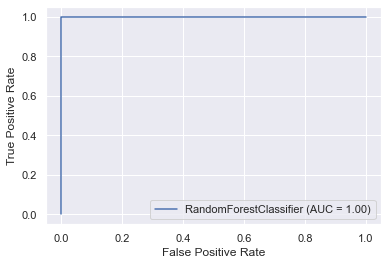

In [50]:
metrics.plot_roc_curve(clf, X_test, y_test)

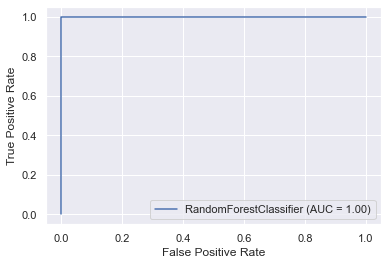

In [51]:
metrics.plot_roc_curve(clf, X_test, pred_y)

## Note

- Benchmark: Compare to "Management Heuristics":
    - All products i.e. 80% Purchase, variance, 

## Features: What drive purchase likelihoods?

- Customer preferences
- Stockpiling (i.e., recent category purchases) leads to purchase patterns in time
- Price (and sensitivity): decreases (increases) lead to increase (decrease) in probability
- Substitution effects (within and across categories), features or functional form of target
- Complementary effects (across categories)

### Feature 1. Product Category

- Interdependencies between products

In [ ]:
# NOTE: Product category defined for ONE shopper

# Question: Should this product category be different for each shopper?

# Co-occurrence matrix
# 1. Define category based on correlation
# 2. Apply those category to existing table ?

In [ ]:
# basket dataframe with shoppers < 2_000
b_os.head(1)

In [ ]:
bb_os = b_os.copy()
bb_os.head()

#### Attempt #1. Cooccurrences

In [ ]:
# Group products by weeks

product_list_groupby_week = bb_os.groupby("week")["product"].apply(list).reset_index()
product_list_groupby_week = product_list_groupby_week["product"].values
product_list_groupby_week[0:1]

In [ ]:
# Matrix declaration
dim = (250, 250)
mat = np.zeros(dim)
mat[0,0]

In [ ]:
def create_cooccurrences(product_list_groupby_week, num_total_prods):

    # Declare matrix with a size of total products
    dim = (num_total_prods, num_total_prods)
    mat = np.zeros(dim)
    
    # Loop through each week and double-for-loop to register values
    for l in product_list_groupby_week:
        for i in l:
            for j in l:
                mat[i,j] += 1
    return mat    

In [ ]:
cooc = create_cooccurrences(product_list_groupby_week, 250)
cooc

In [ ]:
# Visualize it

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches

# sns.heatmap(cooc, cmap="coolwarm", annot=True, linewidths=.5)
sns.heatmap(cooc, cmap="coolwarm")

#### Attempt #2. Gensim Word2Vec

In [ ]:
# convert int to str for Word2Vec usage
bb_os["product"] = bb_os["product"].astype(str)

In [ ]:
list_prod_by_week = bb_os.groupby("week")["product"].apply(list).reset_index(name="list_prod")
list_prod_by_week = list_prod_by_week["list_prod"].tolist()

In [ ]:
list_prod_by_week[0:5]

In [ ]:
model_one = Word2Vec(list_prod_by_week)

In [ ]:
model_one.wv.vocab